In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
contaminacion = pd.read_csv("contaminacion_201710-201712.csv")
contaminacion['missing'] = pd.isnull(contaminacion.NO2)

contaminacion.sample(10)

,estacion,zona,timestamp,NO2,O3,PM10,PM2.5,missing
19857,Juan Carlos I,3,2017-12-31 09:00:00,25.0,15.0,NaN,NaN,False
13402,Escuelas Aguirre,1,2017-10-07 09:00:00,39.0,57.0,5.0,3.0,False
9930,El Pardo,4,2017-11-15 18:00:00,81.0,2.0,NaN,NaN,False
24514,Pza. del Carmen,1,2017-10-10 09:00:00,90.0,4.0,NaN,NaN,False
29595,Villaverde Alto,5,2017-11-07 03:00:00,50.0,6.0,NaN,NaN,False
17237,Farolillo,5,2017-12-14 05:00:00,10.0,43.0,5.0,NaN,False
908,Arturo Soria,3,2017-11-07 20:00:00,136.0,5.0,NaN,NaN,False
27489,Tres Olivos,3,2017-11-11 09:00:00,62.0,14.0,42.0,NaN,False
18197,Juan Carlos I,3,2017-10-23 04:00:00,16.0,28.0,NaN,NaN,False
20647,Parque del Retiro,1,2017-11-02 07:00:00,42.0,8.0,NaN,NaN,False


### Ejemplo 1: media

In [3]:
contaminacion['NO2_fill1'] = contaminacion.NO2.where(pd.notna(contaminacion.NO2), contaminacion.NO2.mean())

contaminacion[pd.isna(contaminacion.NO2)].sample(5)

,estacion,zona,timestamp,NO2,O3,PM10,PM2.5,missing,NO2_fill1
7793,Casa de Campo,4,2017-11-18 17:00:00,NaN,NaN,NaN,NaN,True,55.007985
14150,Escuelas Aguirre,1,2017-11-07 14:00:00,NaN,NaN,NaN,NaN,True,55.007985
203,Arturo Soria,3,2017-10-09 10:00:00,NaN,45.0,NaN,NaN,True,55.007985
26707,Tres Olivos,3,2017-10-09 18:00:00,NaN,NaN,28.0,NaN,True,55.007985
22981,Pza. Fernández Ladreda,5,2017-11-07 13:00:00,NaN,21.0,NaN,NaN,True,55.007985


Text(0.5,1,'Promedio NO2 por zona')

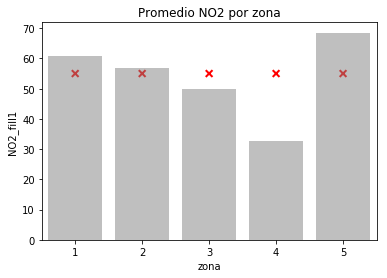

In [95]:
sns.barplot('zona', 'NO2', 
            data=contaminacion.groupby('zona')[['NO2']].mean().reset_index(),
            color='gray', alpha=0.5)

sns.pointplot('zona', 'NO2_fill1', 
              data=contaminacion[contaminacion.missing].groupby('zona')[['NO2_fill1']].min().reset_index(),
              color='red', linestyles="", markers="x")

plt.title("Promedio NO2 por zona")

### Ejemplo 2: media/mediana por estación

In [81]:
contaminacion['NO2_fill2'] = contaminacion.NO2.where(pd.notna(contaminacion.NO2), 
                                                     contaminacion.groupby('estacion').NO2.transform('mean'))
contaminacion[pd.isna(contaminacion.NO2)].sample(5)

,estacion,zona,timestamp,NO2,O3,PM10,PM2.5,missing,NO2_fill1,NO2_fill2
4432,Barrio del Pilar,1,2017-10-01 15:00:00,NaN,76.0,NaN,NaN,True,55.007985,62.602564
25500,Pza. del Carmen,1,2017-11-20 12:00:00,NaN,2.0,NaN,NaN,True,55.007985,59.635374
16903,Farolillo,5,2017-11-30 07:00:00,NaN,NaN,4.0,NaN,True,55.007985,56.990901
24828,Pza. del Carmen,1,2017-10-23 11:00:00,NaN,NaN,NaN,NaN,True,55.007985,59.635374
17797,Juan Carlos I,3,2017-10-06 12:00:00,NaN,92.0,NaN,NaN,True,55.007985,40.696777


Text(0.5,1,'Distribución NO2 por zona')

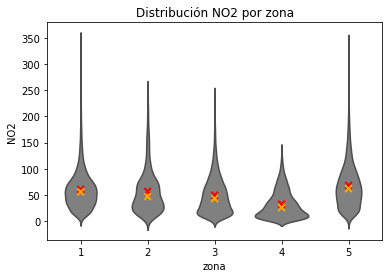

In [97]:
sns.violinplot('zona', 'NO2', data=contaminacion,
               inner=None, color='gray', alpha=0.5)

sns.pointplot('zona', 'NO2', 
              data=contaminacion.groupby('zona')[['NO2']].mean().reset_index(),
              color='red', linestyles="", markers="x")

sns.pointplot('zona', 'NO2', 
              data=contaminacion.groupby('zona')[['NO2']].median().reset_index(),
              color='orange', linestyles="", markers="x")

plt.title("Distribución NO2 por zona")

Text(0.5,1,'Distribución NO2 por estación (zona 4)')

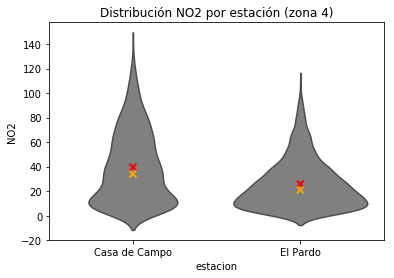

In [105]:
sns.violinplot('estacion', 'NO2', data=contaminacion[contaminacion.zona == 4],
               inner=None, color='gray', alpha=0.5)

sns.pointplot('estacion', 'NO2', 
              data=contaminacion[contaminacion.zona == 4].groupby('estacion')[['NO2']].mean().reset_index(),
              color='red', linestyles="", markers="x")

sns.pointplot('estacion', 'NO2', 
              data=contaminacion[contaminacion.zona == 4].groupby('estacion')[['NO2']].median().reset_index(),
              color='orange', linestyles="", markers="x")

plt.title("Distribución NO2 por estación (zona 4)")

### Ejemplo 3: imputación aleatoria por estación

### Ejemplo 4: imputación por regresión

#### Regresión lineal

#### Árbol de decisión

### Ejemplo 5: imputación temporal con última observación